In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Concatenate, Add, Multiply,Average, Subtract
from tensorflow.keras.models import Model
import traffic_data_generator
import traffic_util

Fix the random seeds in numpy, tensorlfow

In [3]:
import random as rn

rand_seed=116
rn.seed(rand_seed)
np.random.seed(rand_seed)
tf.random.set_seed(rand_seed)


In [8]:
class Xing_1995 ():
    def __init__(self,delta_t,T1,T2):
        self.alpha=.5
        self.beta=.05
        self.T1=T1
        self.T2=T2
        self.delta_t=delta_t
        
    def acc_func(self,v,x):
        T1_n_steps=int(round(self.T1/self.delta_t))
        T2_n_steps=int(round(self.T2/self.delta_t))
        i_T1=np.max([v.shape[1]-T1_n_steps,0])
        i_T2=np.max([x.shape[1]-T2_n_steps,0])
        delta_v=v[0,i_T1]-v[1,i_T1]
        delta_x=x[0,i_T2]-x[1,i_T2]
        D_n=7+.5*v[1,i_T2]
        return self.alpha*delta_v+self.beta*(delta_x-D_n)

In [9]:
class GHR ():
    def __init__(self, c, m,l,T1,T2):
        self.c=c
        self.m=m
        self.l=l
        self.T1=T1
        self.T2=T2
        
    def acc_func(self,v,delta_x, delta_v):
        T1_n_steps=int(round(self.T1/self.delta_t))
        T2_n_steps=int(round(self.T2/self.delta_t))
        i_T1=np.max([v.shape[1]-T1_n_steps,0])
        i_T2=np.max([x.shape[1]-T2_n_steps,0])
        delta_v=v[0,i_T1]-v[1,i_T1]
        delta_x=x[0,i_T2]-x[1,i_T2]
        if abs(delta_x)<10**-12:
            delta_x=10**-12
        return v[0,0]**self.m*self.c*delta_v/delta_x**self.l

In [10]:
class Helbing ():
    def __init__(self,V_0,tau,V_e,s,R,tau_prime,T1,T2,delta_t):
        self.V_0=V_0
        self.tau=tau
        self.V_e=V_e
        self.s=s
        self.R=R
        self.tau_prime=tau_prime
        self.T1=T1
        self.T2=T2
        self.delta_t=delta_t
        
    def acc_func(self,v,x):
        T1_n_steps=int(round(self.T1/self.delta_t))
        T2_n_steps=int(round(self.T2/self.delta_t))
        i_T1,i_T2=None,None
        if len(v.shape)==2: i_T1=np.max([v.shape[1]-T1_n_steps-1,0])
        if len(x.shape)==2: i_T2=np.max([x.shape[1]-T2_n_steps-1,0])
        if len(v.shape)==2: v_current=v[1,0]
        else: v_current=v[1]
        delta_v=v[0,i_T1]-v[1,i_T1]
        delta_x=x[0,i_T2]-x[1,i_T2]
        return (self.V_e(delta_x)-v_current)/self.tau-np.exp((delta_x-s(v_current))/-self.R)*(-delta_v/self.tau_prime)*(-delta_v>0)

In [84]:
class Aw ():
    def __init__(self,C,gamma,A,T_r,car_length,V,T1,T2,delta_t):
        self.C=C
        self.gamma=gamma
        self.T_r=T_r
        self.car_length=car_length
        self.V=V
        self.T1=T1
        self.T2=T2
        self.delta_t=delta_t    
        
    def acc_func(self,v,x):
        T1_n_steps=int(round(self.T1/self.delta_t))
        T2_n_steps=int(round(self.T2/self.delta_t))
        i_T1,i_T2=None,None
        if len(v.shape)==2: i_T1=np.max([v.shape[1]-T1_n_steps-1,0])
        if len(x.shape)==2: i_T2=np.max([x.shape[1]-T2_n_steps-1,0])
        if len(v.shape)==2: v_current=v[1,0]
        else: v_current=v[1]
        delta_v=v[0,i_T1]-v[1,i_T1]
        delta_x=x[0,i_T2]-x[1,i_T2]
        return self.C*delta_v/delta_x**(self.gamma+1)+A/T_r*(V(self.car_length/delta_x)-v_current)

In [22]:
def init_loc(separation_mean,separation_var,loc_init,n_cars):
    init_loc_matrix = np.zeros(n_cars)
    if loc_init=='equal_space':
        init_loc_matrix = -np.arange(n_cars)*separation_mean
    elif loc_init=='uniform':
        separation_vector=np.random.uniform(separation_mean-np.sqrt(separation_var*3),separation_mean+np.sqrt(separation_var*3),n_cars-1)
        init_loc_matrix[0] = 0
        for i_car in range(n_cars-1):
            init_loc_matrix[i_car+1] = init_loc_matrix[i_car]-separation_vector[i_car]
    return init_loc_matrix

def init_vel(lead_car_speed,vel_init,vel_init_mean,vel_init_var,n_cars):
    
    init_vel_matrix = np.zeros(n_cars)
    if vel_init=='uniform':
        init_vel_matrix=np.random.uniform(vel_init_mean-np.sqrt(vel_init_var*3),vel_init_mean+np.sqrt(vel_init_var*3),n_cars)
    elif vel_init=='constant':
        init_vel_matrix=np.ones(n_cars)*vel_init_mean
    elif vel_init=='normal':
        init_vel_matrix=np.max([np.zeros(n_cars),np.random.normal(vel_init_mean,vel_init_var,n_cars)],axis=0)
    init_vel_matrix[0]=lead_car_speed
    return init_vel_matrix
    
def simulation_1(init_loc_matrix,init_vel_matrix,delta_gen,traj_len,acc_function):
    
    n_t_steps_traj=int(round(traj_len/delta_gen))
    T1=T2=0
    T1_n_steps=int(round(T1/delta_gen))
    T2_n_steps=int(round(T2/delta_gen))
    
    loc_matrix = np.zeros([n_cars,n_t_steps_traj])
    loc_matrix[:,0]=init_loc_matrix
    vel_matrix = np.zeros([n_cars,n_t_steps_traj])  
    vel_matrix[:,0]=init_vel_matrix
    acc_matrix = np.zeros([n_cars,n_t_steps_traj])

    time = np.arange(n_t_steps_traj)*delta_gen

    loc_matrix[0,:] = init_vel_matrix[0]*time
    vel_matrix[0,:] = init_vel_matrix[0]+0*time
    acc_matrix[0,:] = 0*time

    for i in range(n_t_steps_traj-1):
        i_T1=np.max([i-T1_n_steps,0])
        i_T2=np.max([i-T2_n_steps,0])
        for j in range(1,n_cars):
            acc_matrix[j, i+1] = acc_function(vel_matrix[j-1:j+1,i_T1:i+1],
                                              loc_matrix[j-1:j+1,i_T1:i+1])
            vel_matrix[j, i+1] = vel_matrix[j, i] + acc_matrix[j, i+1]*delta_gen
            loc_matrix[j, i+1] = loc_matrix[j, i] + vel_matrix[j, i]*delta_gen + acc_matrix[j, i+1]*delta_gen**2/2

    for i in range(1,n_cars):
        loc_matrix[i,:] -= loc_matrix[0,:]   
    loc_matrix[0,:] -= loc_matrix[0,:]  
    
    return loc_matrix,vel_matrix,acc_matrix


In [169]:
example_name="traffic"
data_dir=traffic_data_generator.set_up(example_name)

In [173]:
delta_gen=0.05
n_samples=100000
data_dir

'./traffic/Data'

In [171]:
#===========================
#     Output directories 
#===========================
experiment_name="_no_share"+ \
     "_"+str(n_samples)+"_Delta_"+str(delta_gen)


model_dir=example_name+"/"+experiment_name
plot_dir=model_dir+"/Plots"
checkpoint_dir=model_dir+"/check_points"

if not os.path.exists(model_dir):
    os.mkdir(model_dir)
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

In [180]:
# domain=np.array([#[20,100],#n_cars
#                  [3,10], #tau
#                  [45.,75], #R
#                  [10,80.], #vel_init_mean
#                  [-20,60.], #separation_mean+s(vel_mean)    
# ])

#This is for Aw w/o scaling to 60 ft/sec
domain=np.array([[600,600],#n_cars
                 [5,5], #T_r
                 [.8,1.2], #C
                 [.5,1], #rho_max
                 [1.3,1.3], #v_max
                 [1,1], #vel_init_mean
                 [.1,.1], #vel_variance as fraction of meean
                 [2,2], #separation_mean
                 [.1,.1], #separation_variance as fraction of meean
])


# #This is for Aw w/ scaling to 60 ft/sec
# domain=np.array([#[20,100],#n_cars
#                  [20,20], #T_r
#                  [1,1], #C
#                  [31/100,31/100], #rho_max
#                  [80,80], #v_max
# ])

ith_run=0
new_run=True
while os.path.exists(data_dir+'/parameters AW'+str(ith_run)+ 'd_gen='+str(delta_gen) + 'n_samples='+str(n_samples)+'.npy'):
    domain_temp=np.load(data_dir+'/parameters AW'+str(ith_run)+ 'd_gen='+str(delta_gen) + 'n_samples='+str(n_samples)+'.npy')
    if np.all(domain==domain_temp):
        new_run=False
        break
    else:
        ith_run+=1
if new_run:
    np.save(data_dir+'/parameters AW'+str(ith_run)+ 'd_gen='+str(delta_gen) + 'n_samples='+str(n_samples)+'.npy', domain)


In [ ]:
d = np.arange(2**4)
combo=(((d[:,None] & (1 << np.arange(4)))) > 0).astype(int)

In [183]:
int(np.random.uniform(domain[0,0],domain[0,1]))

600

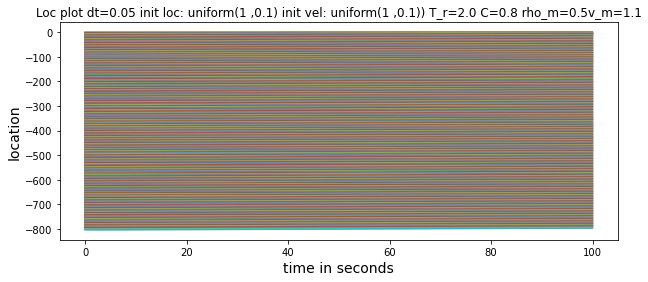

In [96]:
for i_combo in range(1): # range(len(combo)):
    this_combo=combo[i_combo]
    traj_len=100 # total time 
    n_cars=800 #int(domain[0,this_combo[0]])

# This is for Helbing Parameters
#     V_0=60
#     tau1=domain[0,this_combo[0]]
#     def V_e(x): return V_0*(np.tanh(x-2)+np.tanh(2))
#     car_length=31 # this is car length plus comfortable stopped distance
#     def s(v): return car_length+v*4 #this is an implementation of the 4 second following rule
#     R=domain[1,this_combo[1]]
#     tau2=tau1
#     T1=T2=0
#     acc_function=Helbing(V_0,tau1,V_e,s,R,tau2,T1,T2,delta_gen).    
    
    C=domain[1,this_combo[1]]
    gamma=0
    A=1
    T_r=domain[0,this_combo[0]]
    car_length=1/40 
#     car_length=31
    v_max=domain[3,this_combo[3]]
    def U(rho):return v_max*(np.pi/2.+ np.arctan(11*(rho-.22)/(rho-1)))/(np.pi/2 + np.arctan(11*.22))
    rho_max=domain[2,this_combo[2]]
    def V(rho): return U(rho/rho_max)
    T1=T2=0
    acc_function=Aw(C,gamma,A,T_r,car_length,V,T1,T2,delta_gen).acc_func

    lead_car_speed=1
#     lead_car_speed=60
    vel_init='uniform'
    #vel_init_mean=domain[2,this_combo[2]]
    vel_init_mean=1
#     vel_init_mean=60
    vel_init_var=.1*vel_init_mean

    init_vel_matrix=init_vel(lead_car_speed,vel_init,vel_init_mean,vel_init_var,n_cars)

#     separation_mean=s(vel_init_mean)+domain[3,this_combo[3]] # in cars/foot
    separation_mean=1
#     separation_mean=270
    separation_var=.1*abs(separation_mean)
    loc_init='uniform'

    init_loc_matrix= init_loc(separation_mean,separation_var,loc_init,n_cars)

    loc_matrix,vel_matrix,acc_matrix=simulation_1(init_loc_matrix,init_vel_matrix,delta_gen,traj_len,acc_function)

    
    plt.figure(figsize=(10,4))
    time = np.arange(int(round(traj_len/delta_gen)))*delta_gen
    for i in range(n_cars):
        plt.plot(time,loc_matrix[i,:])
    # plt.ylim(-400,20)
    plt.title('Loc plot dt=' + str(delta_gen) + ' init loc: '+ loc_init + "(" + str(separation_mean) + ' ,' + str(round(separation_var,3)) +
              ') init vel: '+ vel_init + "(" + str(vel_init_mean) + ' ,' + str(vel_init_var) + ")"+
              ") T_r=" + str(T_r)+ " C=" + str(C)+ " rho_m=" +str(rho_max) +"v_m=" +str(v_max))
    plt.xlabel('time in seconds', fontsize=14)
    plt.ylabel('location', fontsize=14)
    plt.show()
    

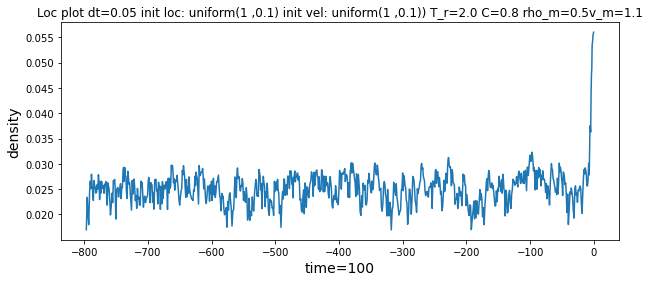

In [139]:
n_t_steps_traj=int(round(traj_len/delta_gen))
rho_matrix=np.zeros([n_cars-1,n_t_steps_traj])
rho_matrix=car_length/(loc_matrix[:n_cars-1,:]-loc_matrix[1:,:])
plt.figure(figsize=(10,4))
time = 100
plt.plot(loc_matrix[1:,int(round(time/delta_gen))-1],rho_matrix[:,int(round(time/delta_gen))-1])
# plt.ylim(-400,20)
plt.title('Loc plot dt=' + str(delta_gen) + ' init loc: '+ loc_init + "(" + str(separation_mean) + ' ,' + str(round(separation_var,3)) +
          ') init vel: '+ vel_init + "(" + str(vel_init_mean) + ' ,' + str(vel_init_var) + ")"+
          ") T_r=" + str(T_r)+ " C=" + str(C)+ " rho_m=" +str(rho_max) +"v_m=" +str(v_max))
plt.xlabel('lagrangian density at time='+str(time), fontsize=14)
plt.ylabel('density', fontsize=14)
plt.show()

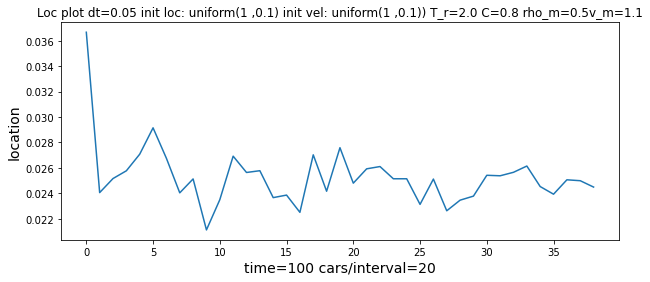

In [136]:
n_low_res=20
time =100
n_t_steps_traj=int(round(traj_len/delta_gen))
n_intervals=int(n_cars/n_low_res)-1
low_res_rho_matrix=np.zeros([n_intervals,n_t_steps_traj])
low_res_rho_matrix=n_low_res*car_length/(loc_matrix[0:n_cars-n_low_res:n_low_res,:]-loc_matrix[n_low_res::n_low_res,:])
plt.figure(figsize=(10,4))

plt.plot(low_res_rho_matrix[:,int(round(time/delta_gen))-1])
# plt.ylim(-400,20)
plt.title('Loc plot dt=' + str(delta_gen) + ' init loc: '+ loc_init + "(" + str(separation_mean) + ' ,' + str(round(separation_var,3)) +
          ') init vel: '+ vel_init + "(" + str(vel_init_mean) + ' ,' + str(vel_init_var) + ")"+
          ") T_r=" + str(T_r)+ " C=" + str(C)+ " rho_m=" +str(rho_max) +"v_m=" +str(v_max))
plt.xlabel('time='+ str(time) + ' cars/interval=' + str(n_low_res), fontsize=14)
plt.ylabel('density', fontsize=14)
plt.show()

In [142]:
A=np.zeros(2)
A[0]="hello"

ValueError: could not convert string to float: 'hello'

NameError: name 'R' is not defined

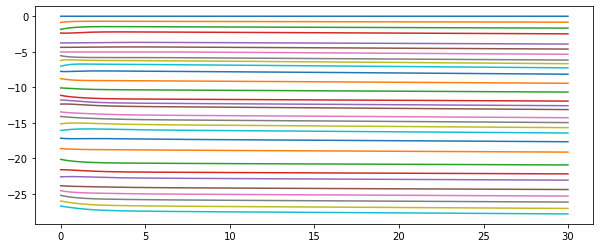

In [42]:
plt.figure(figsize=(10,4))
time = np.arange(int(round(traj_len/delta_gen)))*delta_gen
for i in range(n_cars):
    plt.plot(time,loc_matrix[i,:])
# plt.ylim(-400,20)
plt.title('Loc plot dt=' + str(delta_gen) + ' init loc: '+ loc_init + "(" + str(separation_mean) + ' ,' + str(separation_var) +
          ' init vel: '+ vel_init + "(" + str(vel_init_mean) + ' ,' + str(vel_init_var) + ")"+
          " R=" + str(R)+ " tau=" + str(tau1))
plt.xlabel('time in seconds', fontsize=14)
plt.ylabel('location', fontsize=14)
plt.show()

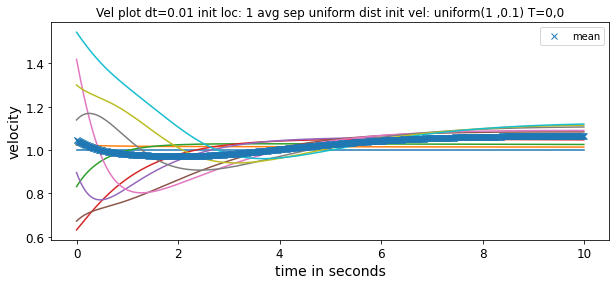

In [68]:
plt.figure(figsize=(10,4))
for i in range(n_cars):
    plt.plot(time,vel_matrix[i,:])
plt.plot(time,np.mean(vel_matrix,axis=0),'x',label='mean')
plt.title('Vel plot dt=' + str(delta_gen) + ' init loc: ' + str(separation_mean) + ' avg sep ' + loc_init +
          ' dist init vel: '+ vel_init + "(" + str(vel_init_mean) + ' ,' + str(round(vel_init_var,3)) + ")"+
          " T=" + str(T1) + "," +str(T2))
plt.xlabel('time in seconds', fontsize=14)
plt.ylabel('velocity', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(59,66)
# plt.xlim(280,300)
plt.legend()
plt.show()

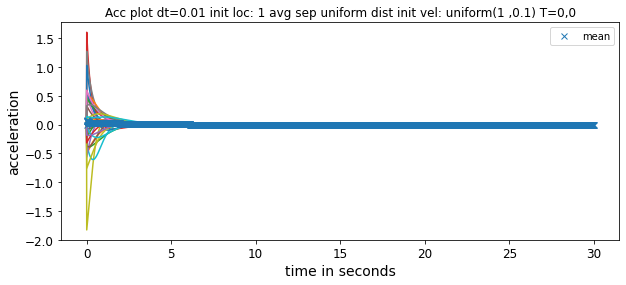

In [43]:
plt.figure(figsize=(10,4))
for i in range(n_cars):
    plt.plot(time,acc_matrix[i,:])
plt.plot(time,np.mean(acc_matrix,axis=0),'x',label='mean')
plt.title('Acc plot dt=' + str(delta_gen) + ' init loc: ' + str(separation_mean) + ' avg sep ' + loc_init +
          ' dist init vel: '+ vel_init + "(" + str(vel_init_mean) + ' ,' + str(vel_init_var) + ")"+
          " T=" + str(T1) + "," +str(T2))
plt.xlabel('time in seconds', fontsize=14)
plt.ylabel('acceleration', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

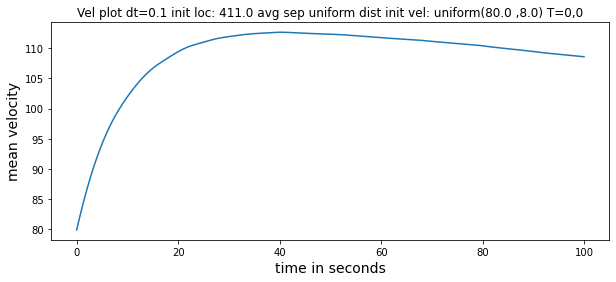

In [293]:
plt.figure(figsize=(10,4))
plt.plot(time,np.mean(vel_matrix,axis=0))
plt.xlabel('time in seconds', fontsize=14)
plt.ylabel('mean velocity', fontsize=14)
plt.title('Vel plot dt=' + str(delta_gen) + ' init loc: ' + str(separation_mean) + ' avg sep ' + loc_init +
          ' dist init vel: '+ vel_init + "(" + str(vel_init_mean) + ' ,' + str(vel_init_var) + ")"+
          " T=" + str(T1) + "," +str(T2))
plt.show()

In [244]:
#This returns an array with first column the location of the start of the bin, the second column as the density (number of cars)
#in that bin and the third as the average velocity of the cars in that bin. 
#NOTE the last entry for column 2 and 3 is always zero to allow us to define intervals well.
def indicator_func(x,v,bin_size,n_bins):
    bin_matrix=np.zeros([3,n_bins+1])
    bin_matrix[0]=-np.arange(n_bins+1)*bin_size
    ind=np.argsort(x)[::-1]
    bin_indicator=np.ceil(x[ind]/bin_size)
    v_sorted=v[ind]
    bin_end=np.zeros(n_bins+1,dtype=int)
    for i_bin in range(1,n_bins+1):
        bin_end[i_bin]=bin_end[i_bin-1]
        if -i_bin+1 in bin_indicator:
            bin_end[i_bin]=np.where(bin_indicator==-i_bin+1)[0][-1]
            bin_matrix[1,i_bin-1]=bin_end[i_bin]-bin_end[i_bin-1]+(i_bin==1)
            bin_matrix[2,i_bin-1]=np.mean(v_sorted[bin_end[i_bin-1]+(i_bin>1):bin_end[i_bin]+1])
    return bin_matrix
    
    

In [48]:
indicator_func(loc_matrix[:,0],vel_matrix[:,0],1056,8)

array([[ 0.00000000e+00, -1.05600000e+03, -2.11200000e+03,
        -3.16800000e+03, -4.22400000e+03, -5.28000000e+03,
        -6.33600000e+03, -7.39200000e+03, -8.44800000e+03],
       [ 3.00000000e+00,  3.00000000e+00,  2.00000000e+00,
         3.00000000e+00,  3.00000000e+00,  2.00000000e+00,
         3.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 5.35446804e+01,  5.05427612e+01,  5.11529625e+01,
         5.02985267e+01,  4.97463833e+01,  4.96141978e+01,
         4.93049971e+01,  4.98187085e+01,  0.00000000e+00]])

In [257]:
n_bin_time_step=traj_len
delta_t_bin=1
n_bins=1000
bin_size=1000
histogram_matrix=np.zeros([n_bin_time_step,3,n_bins+1])
for i_bin_time in range(n_bin_time_step):
    bin_time_int=int(round(delta_t_bin/delta_gen))*i_bin_time
    histogram_matrix[i_bin_time,:,:]=indicator_func(loc_matrix[:,bin_time_int],vel_matrix[:,bin_time_int],bin_size,n_bins)

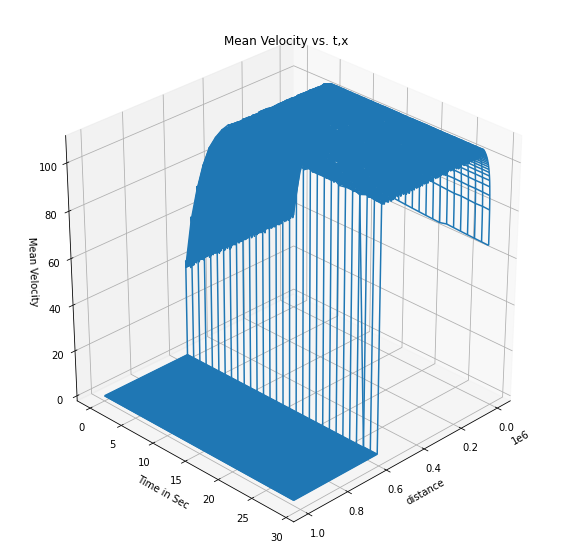

In [258]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

_x = np.arange(n_bin_time_step)*delta_t_bin
_y = np.arange(n_bins+1)*bin_size
_xx, _yy = np.meshgrid(_x, _y)

ax.plot_wireframe(_yy[:n_bins,:],_xx[:n_bins,:],np.transpose(histogram_matrix[:,2,:n_bins]), rstride=2, cstride=1)
ax.view_init(30, 45)
ax.set_xlabel('distance')
ax.set_ylabel('Time in Sec')
ax.set_zlabel('Mean Velocity')
ax.set_title('Mean Velocity vs. t,x')
plt.show()

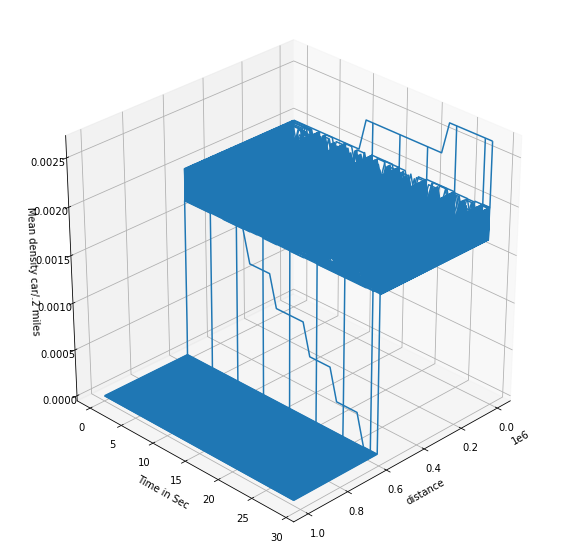

In [259]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(_yy[:n_bins,:],_xx[:n_bins,:],np.transpose(histogram_matrix[:,1,:n_bins])/n_cars, rstride=2, cstride=4)
ax.view_init(30, 45)
ax.set_xlabel('distance')
ax.set_ylabel('Time in Sec')
ax.set_zlabel('Mean density car/.2 miles')
plt.show()

In [493]:
histogram_matrix[]

array([[[ 0.00000000e+00, -1.05600000e+03, -2.11200000e+03,
         -3.16800000e+03, -4.22400000e+03, -5.28000000e+03,
         -6.33600000e+03],
        [ 4.00000000e+00,  4.00000000e+00,  3.00000000e+00,
          4.00000000e+00,  3.00000000e+00,  2.00000000e+00,
          0.00000000e+00],
        [ 5.24772564e+01,  4.94064259e+01,  5.00052901e+01,
          4.94878244e+01,  5.04736319e+01,  4.93805528e+01,
          0.00000000e+00]],

       [[ 0.00000000e+00, -1.05600000e+03, -2.11200000e+03,
         -3.16800000e+03, -4.22400000e+03, -5.28000000e+03,
         -6.33600000e+03],
        [ 4.00000000e+00,  4.00000000e+00,  3.00000000e+00,
          4.00000000e+00,  3.00000000e+00,  2.00000000e+00,
          0.00000000e+00],
        [ 6.52305066e+01,  7.24737127e+01,  7.65292506e+01,
          7.92624962e+01,  7.90636382e+01,  7.63206538e+01,
          0.00000000e+00]],

       [[ 0.00000000e+00, -1.05600000e+03, -2.11200000e+03,
         -3.16800000e+03, -4.22400000e+03, -5.28000000

In [173]:
a=(def log(x): return np.log(x))

SyntaxError: invalid syntax (<ipython-input-173-c3ef5cc084e3>, line 1)

In [172]:
lagrangian is length car/dist btwn cars

1.0986122886681098

In [ ]:
eulerian is cars in bin/number cars

In [ ]:
cars in bin * length of car/ length of bin